In [1]:
import os
import glob
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [2]:
run = 'pi03'
years = np.arange(1850,1860)

rho = 1000
months = np.arange(1,13)

#Prepare diagnostic variables
SF   = np.zeros((len(years),len(months)))
EVP  = np.zeros((len(years),len(months)))

SFex = np.zeros((len(years),len(months)))
MLT  = np.zeros((len(years),len(months)))

CAL  = np.zeros((len(years),len(months)))
RO   = np.zeros((len(years),len(months)))

RSs  = np.zeros((len(years),len(months)))
RSm  = np.zeros((len(years),len(months)))


#Read generic NEMO data
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['O1t0.srf'].values;
ds.close()
ds = xr.open_dataset(f'../data/ecefiles/{run}/{run}_1m_{years[0]}0101_{years[0]}1231_grid_T.nc')
lat = ds['nav_lat'].values
lon = ds['nav_lon'].values
time_bnds = ds['time_centered_bounds']
mask = np.where(lat<-58,1,0)
ds.close()

#Extract diagnostics
for y,yy in enumerate(years):
    ds = xr.open_dataset(f'../data/ecefiles/{run}/{run}_1m_{yy}0101_{yy}1231_grid_T.nc')
    calv = ds['calving'].values
    rnf  = ds['friver'].values
    
    for m,mm in enumerate(months):
        secs = (time_bnds[m,1]-time_bnds[m,0]).values / np.timedelta64(1, 's')
        CAL[y,m] = np.nansum(calv[m,:,:]*area*mask*secs*1e-12)
        RO[y,m]  = np.nansum(rnf[m,:,:]*area*mask*secs*1e-12)
    print(f'{yy}: CAL: {np.sum(CAL[y,:]):.0f} Gt/yr | RO: {np.sum(RO[y,:]):.0f} Gt/yr')


#Read generic IFS data
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['A128.srf'].values
ds.close()
ds = xr.load_dataset(f"../data/ecefiles/{run}/ICMGG{run}+{years[0]}01",engine='cfgrib')
lon = ds['longitude'].values
lat = ds['latitude'].values
ds.close()
mask = np.where(lat<-60,1,0)

#Extract diagnostics
for y,yy in enumerate(years):
    for m,mm in enumerate(months):
        fname = f"../data/ecefiles/{run}/ICMGG{run}+{yy}{mm:02d}"
        ds = xr.load_dataset(fname,engine='cfgrib')
        time = ds.time.values
        sf = ds.sf.values
        sd = ds.sd.values
        mlt = ds.smlt.values
        evp = ds.es.values
        ds.close()
        
        SF[y,m]   = np.nansum(sf*np.where(sd>0,1,0)*mask*area*rho*1e-12)
        SFex[y,m] = np.nansum(sf*np.where(sd==10,1,0)*mask*area*rho*1e-12)
        MLT[y,m]  = np.nansum(mlt*np.where(sd>0,1,0)*mask*area*rho*1e-12)
        EVP[y,m]  = np.nansum(evp*np.where(sd>0,1,0)*mask*area*rho*1e-12)
        
        RSs[y,m]  = SF[y,m] - SFex[y,m] - MLT[y,m] + EVP[y,m]
        RSm[y,m]  = SF[y,m] - CAL[y,m] - RO[y,m] + EVP[y,m]

        #print(f'Got {yy} {mm}')
    print(f'{yy}: SF: {np.sum(SF[y,:]):.0f} | SFex: {np.sum(SFex[y,:]):.0f} | MLT: {np.sum(MLT[y,:]):.0f} | EVP: {np.sum(EVP[y,:]):.0f} Gt/yr')    

1850: CAL: 2997 Gt/yr | RO: 331 Gt/yr
1851: CAL: 2716 Gt/yr | RO: 364 Gt/yr
1852: CAL: 2837 Gt/yr | RO: 290 Gt/yr
1853: CAL: 2868 Gt/yr | RO: 306 Gt/yr
1854: CAL: 3213 Gt/yr | RO: 372 Gt/yr
1855: CAL: 2926 Gt/yr | RO: 428 Gt/yr
1856: CAL: 2624 Gt/yr | RO: 352 Gt/yr
1857: CAL: 3015 Gt/yr | RO: 364 Gt/yr
1858: CAL: 3010 Gt/yr | RO: 407 Gt/yr
1859: CAL: 2639 Gt/yr | RO: 384 Gt/yr
1850: SF: 3646 | SFex: 3004 | MLT: 352 | EVP: -259 Gt/yr
1851: SF: 3346 | SFex: 2719 | MLT: 379 | EVP: -278 Gt/yr
1852: SF: 3440 | SFex: 2841 | MLT: 315 | EVP: -243 Gt/yr
1853: SF: 3476 | SFex: 2885 | MLT: 343 | EVP: -256 Gt/yr
1854: SF: 3798 | SFex: 3204 | MLT: 395 | EVP: -240 Gt/yr
1855: SF: 3561 | SFex: 2930 | MLT: 448 | EVP: -271 Gt/yr
1856: SF: 3318 | SFex: 2633 | MLT: 357 | EVP: -273 Gt/yr
1857: SF: 3645 | SFex: 3015 | MLT: 402 | EVP: -248 Gt/yr
1858: SF: 3671 | SFex: 3009 | MLT: 416 | EVP: -256 Gt/yr
1859: SF: 3298 | SFex: 2650 | MLT: 414 | EVP: -275 Gt/yr


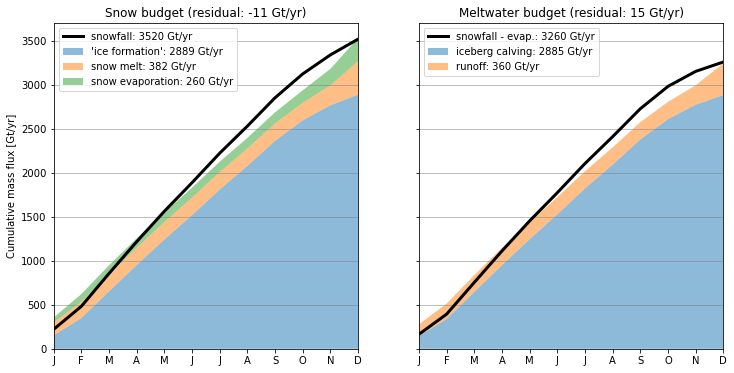

In [3]:
fig,ax = plt.subplots(1,2,figsize=(12,6),sharey=True)

#for y,yy in enumerate(years):
#    ax[0].plot(months,np.cumsum(SF[y,:]),color='k',lw=.3)
#    ax[1].plot(months,np.cumsum(SF[y,:]+EVP[y,:]),color='k',lw=.3)

ax[0].plot(months,np.cumsum(np.mean(SF,axis=0)),label=f'snowfall: {np.sum(np.mean(SF,axis=0)):.0f} Gt/yr',color='k',lw=3)
ax[0].fill_between(months,0.*months,np.cumsum(np.mean(SFex,axis=0)),label=f"'ice formation': {np.sum(np.mean(SFex,axis=0)):.0f} Gt/yr",alpha=.5)
ax[0].fill_between(months,np.cumsum(np.mean(SFex,axis=0)),np.cumsum(np.mean(SFex+MLT,axis=0)),label=f'snow melt: {np.sum(np.mean(MLT,axis=0)):.0f} Gt/yr',alpha=.5)
ax[0].fill_between(months,np.cumsum(np.mean(SFex+MLT,axis=0)),np.cumsum(np.mean(SFex+MLT-EVP,axis=0)),label=f'snow evaporation: {np.sum(np.mean(-EVP,axis=0)):.0f} Gt/yr',alpha=.5)

ax[1].plot(months,np.cumsum(np.mean(SF+EVP,axis=0)),label=f'snowfall - evap.: {np.sum(np.mean(SF+EVP,axis=0)):.0f} Gt/yr',color='k',lw=3)
ax[1].fill_between(months,0.*months,np.cumsum(np.mean(CAL,axis=0)),label=f'iceberg calving: {np.sum(np.mean(CAL,axis=0)):.0f} Gt/yr',alpha=.5)
ax[1].fill_between(months,np.cumsum(np.mean(CAL,axis=0)),np.cumsum(np.mean(CAL+RO,axis=0)),label=f'runoff: {np.sum(np.mean(RO,axis=0)):.0f} Gt/yr',alpha=.5)


ax[0].set_title(f'Snow budget (residual: {np.sum(np.mean(RSs,axis=0)):.0f} Gt/yr)')
ax[1].set_title(f'Meltwater budget (residual: {np.sum(np.mean(RSm,axis=0)):.0f} Gt/yr)')


for v in [0,1]:
    ax[v].legend()
    ax[v].set_xticks(months);
    ax[v].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D']);
    ax[v].grid(True,axis='y',color='.5',lw=.5)
    ax[v].set_ylim(ymin=0)
    ax[v].set_xlim([months[0],months[-1]])
    
ax[0].set_ylabel('Cumulative mass flux [Gt/yr]')

plt.savefig(f'../figures/closed_budgets_{run}.png',dpi=450)
plt.show()

In [7]:
print(f"SF   : {np.mean(np.sum(SF,axis=1)):4.0f} ({np.std(np.sum(SF,axis=1)):3.0f}) Gt/yr")
print(f"SFex : {np.mean(np.sum(SFex,axis=1)):4.0f} ({np.std(np.sum(SFex,axis=1)):3.0f}) Gt/yr")
print(f"MLT  : {np.mean(np.sum(MLT,axis=1)):4.0f} ({np.std(np.sum(MLT,axis=1)):3.0f}) Gt/yr")
print(f"EVP  : {np.mean(np.sum(EVP,axis=1)):4.0f} ({np.std(np.sum(EVP,axis=1)):3.0f}) Gt/yr")
print(f"CAL  : {np.mean(np.sum(CAL,axis=1)):4.0f} ({np.std(np.sum(CAL,axis=1)):3.0f}) Gt/yr")
print(f"RO   : {np.mean(np.sum(RO,axis=1)):4.0f} ({np.std(np.sum(RO,axis=1)):3.0f}) Gt/yr")
print(f"MW   : {np.mean(np.sum(RO+CAL,axis=1)):4.0f} ({np.std(np.sum(RO+CAL,axis=1)):3.0f}) Gt/yr")

SF   : 3520 (162) Gt/yr
SFex : 2889 (173) Gt/yr
MLT  :  382 ( 38) Gt/yr
EVP  : -260 ( 13) Gt/yr
CAL  : 2885 (177) Gt/yr
RO   :  360 ( 40) Gt/yr
MW   : 3244 (187) Gt/yr
